In [ ]:
from imblearn.over_sampling import SMOTE

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import tensorflow as tf
from lxh_visualizaiton import plot_confusion_matrix, draw_pie
from sklearn.metrics import classification_report

from collections import Counter
from lxh_models import DilationNet, VGG16, ResNet18, simple_LSTM, CNN_LSTM, ConvLSTM
from tensorflow.keras.layers import LSTM, Dropout, Dense, Flatten, TimeDistributed, Conv1D, MaxPool1D
import random
# physical_devices = tf.config.list_physical_devices('GPU')
# print(physical_devices)
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

# 1 数据加载与预处理

## 1.1 加载数据

In [3]:
df = pd.read_csv("./train.csv")
df.head()

,id,heartbeat_signals,label
0,0,"0.9912297987616655,0.9435330436439665,0.764677...",0.0
1,1,"0.9714822034884503,0.9289687459588268,0.572932...",0.0
2,2,"1.0,0.9591487564065292,0.7013782792997189,0.23...",2.0
3,3,"0.9757952826275774,0.9340884687738161,0.659636...",0.0
4,4,"0.0,0.055816398940721094,0.26129357194994196,0...",2.0


In [4]:
X_data = []
for signal in df['heartbeat_signals']:
    X_data.append(np.array(signal.split(','), dtype=np.float32))
X_data = np.array(X_data)

## 1.2 数据探索性分析

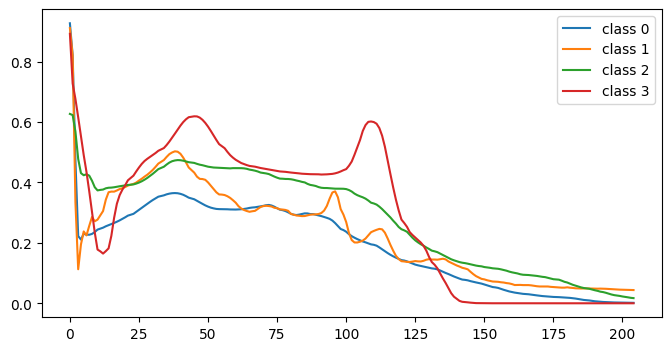

In [9]:
plt.figure(figsize=(8, 4), dpi=100)
for label in range(4):
    plt.plot(X_data[df['label'] == label].mean(axis=0), label=f"class {label}")
plt.legend()
plt.show()

In [5]:
df['label'].value_counts()

0.0    64327
3.0    17912
2.0    14199
1.0     3562
Name: label, dtype: int64

In [6]:
label_num = [df['label'].value_counts()[i] for i in range(4)]

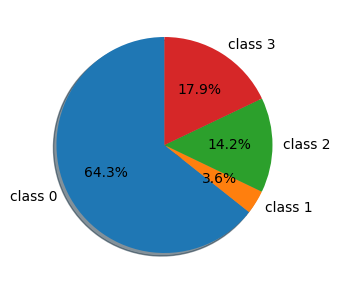

In [7]:
draw_pie(label_num, ['class 0', 'class 1', 'class 2', 'class 3'],figsize=(4, 3))

In [5]:
y_data = df['label'].to_numpy()

In [6]:
random_seed = 233
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=random_seed)
print(X_train.shape, X_test.shape)
X_train = tf.expand_dims(X_train, 2)
y_train = tf.constant(y_train)
X_test = tf.expand_dims(X_test, 2)
y_test = tf.constant(y_test)

(80000, 205) (20000, 205)


# 2 模型的训练和评估

## 2.1 使用类别不平衡的数据训练

Train on 80000 samples
Epoch 1/30
80000/80000 [==============================] - 9s 111us/sample - loss: 0.1483 - accuracy: 0.9542
Epoch 2/30
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0713 - accuracy: 0.9780
Epoch 3/30
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0542 - accuracy: 0.9830
Epoch 4/30
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0431 - accuracy: 0.9860
Epoch 5/30
80000/80000 [==============================] - 8s 105us/sample - loss: 0.0373 - accuracy: 0.9879
Epoch 6/30
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0329 - accuracy: 0.9893
Epoch 7/30
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0285 - accuracy: 0.9908
Epoch 8/30
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0261 - accuracy: 0.9916
Epoch 9/30
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0239 - accuracy: 0.9920
Epoch

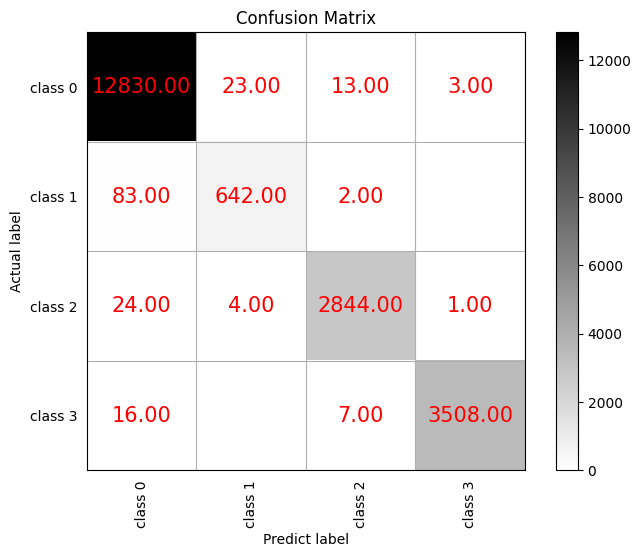

              precision    recall  f1-score   support

     class 0     0.9905    0.9970    0.9937     12869
     class 1     0.9596    0.8831    0.9198       727
     class 2     0.9923    0.9899    0.9911      2873
     class 3     0.9989    0.9935    0.9962      3531

    accuracy                         0.9912     20000
   macro avg     0.9853    0.9659    0.9752     20000
weighted avg     0.9911    0.9912    0.9911     20000

INFO:tensorflow:Assets written to: ./saved_models/net1_2_1_default/assets


In [25]:
model = DilationNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=30)
model.evaluate(X_test, y_test, verbose=2)

y_pred = model.predict(X_test).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))

可以看到类别1的召回率比较低，这很有可能是之前的类别不平衡现象造成的。

## 2.2 使用类别平衡的数据训练

In [26]:
Counter(y_train.numpy())

Counter({0.0: 51458, 3.0: 14381, 2.0: 11326, 1.0: 2835})

### 2.2.1 使用过采样策略进行数据增强

In [6]:
# 使用 SMOTE 对数据进行上采样以解决类别不平衡问题
smote = SMOTE(random_state=random_seed, n_jobs=-1)
k_X_train, k_y_train = smote.fit_resample(tf.reshape(X_train, (X_train.shape[0], X_train.shape[1])), y_train)  
k_X_train = tf.expand_dims(k_X_train, 2)
print(f"after smote, k_X_train.shape: {k_X_train.shape}, k_y_train.shape: {k_y_train.shape}")

after smote, k_X_train.shape: (205832, 205, 1), k_y_train.shape: (205832,)


In [9]:
Counter(k_y_train)

Counter({0.0: 51458, 3.0: 51458, 2.0: 51458, 1.0: 51458})

In [7]:
k_y_train = tf.constant(k_y_train)

Train on 205832 samples
Epoch 1/30
205832/205832 [==============================] - 24s 116us/sample - loss: 0.1077 - accuracy: 0.9613
Epoch 2/30
205832/205832 [==============================] - 23s 113us/sample - loss: 0.0379 - accuracy: 0.9876
Epoch 3/30
205832/205832 [==============================] - 23s 113us/sample - loss: 0.0263 - accuracy: 0.9917
Epoch 4/30
205832/205832 [==============================] - 23s 112us/sample - loss: 0.0214 - accuracy: 0.9932
Epoch 5/30
205832/205832 [==============================] - 23s 112us/sample - loss: 0.0175 - accuracy: 0.9945
Epoch 6/30
205832/205832 [==============================] - 23s 113us/sample - loss: 0.0162 - accuracy: 0.9952
Epoch 7/30
205832/205832 [==============================] - 23s 112us/sample - loss: 0.0143 - accuracy: 0.9956
Epoch 8/30
205832/205832 [==============================] - 23s 113us/sample - loss: 0.0136 - accuracy: 0.9961
Epoch 9/30
205832/205832 [==============================] - 23s 112us/sample - loss: 0.0

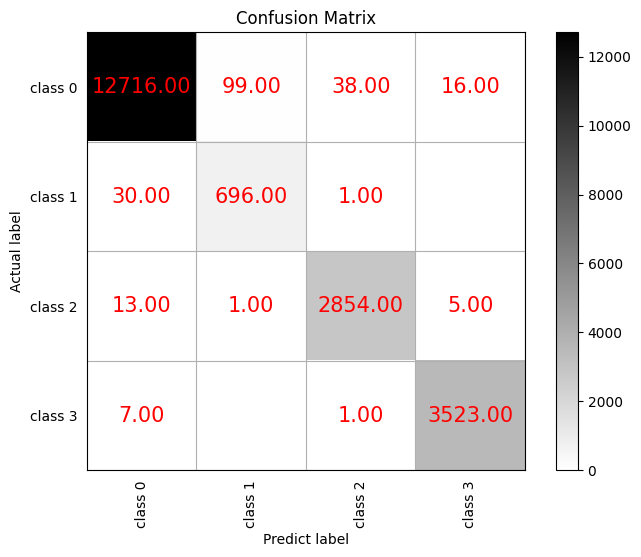

              precision    recall  f1-score   support

     class 0     0.9961    0.9881    0.9921     12869
     class 1     0.8744    0.9574    0.9140       727
     class 2     0.9862    0.9934    0.9898      2873
     class 3     0.9941    0.9977    0.9959      3531

    accuracy                         0.9895     20000
   macro avg     0.9627    0.9841    0.9729     20000
weighted avg     0.9899    0.9895    0.9896     20000

INFO:tensorflow:Assets written to: ./saved_models/net1_2_2_1_default/assets


In [36]:
model = DilationNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(k_X_train, k_y_train, epochs=30)
model.evaluate(X_test, y_test, verbose=2)

y_pred = model.predict(X_test).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))
model.save("./saved_models/DilationNet1_2_2_1_default/DilationNet1_2_2_1_default")

可以看到class 1的召回率被捞上来了一点，但是精确度却下去了。

### 2.2.2 使用欠采样策略训练多个模型后集成

In [6]:
def uniform_sample(X, y, n_sample, classes, random_seed=233):
    r"""
    对每一类别均匀采样
    """
    X_new = []
    y_new = []
    for i in range(classes):
        X_tmp = X[y == i]
        y_tmp = y[y == i]
        assert n_sample <= len(X_tmp), f"类别{i}样本数不足{n_sample}!"
        X_new.append(X_tmp[random.sample(range(len(X_tmp)), n_sample)])
        y_new.append(y_tmp[0:n_sample])
    X_new, y_new = np.concatenate(X_new), np.concatenate(y_new)
    np.random.seed(random_seed)
    np.random.shuffle(X_new)
    np.random.seed(random_seed)
    np.random.shuffle(y_new)
    return X_new, y_new

In [9]:
Counter(y_train.numpy()).values()

dict_values([51458, 14381, 11326, 2835])

In [12]:
u_X_train, u_y_train = uniform_sample(X_train.numpy(), y_train.numpy(), 2500, 4)
u_X_train, u_y_train = tf.constant(u_X_train), tf.constant(u_y_train)

In [26]:
Counter(u_y_train.numpy()).values()

dict_values([2500, 2500, 2500, 2500])

Train on 10000 samples
Epoch 1/30
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.5504 - accuracy: 0.7711
Epoch 2/30
10000/10000 [==============================] - 10s 965us/sample - loss: 0.2586 - accuracy: 0.9000
Epoch 3/30
10000/10000 [==============================] - 10s 960us/sample - loss: 0.1961 - accuracy: 0.9256
Epoch 4/30
10000/10000 [==============================] - 10s 961us/sample - loss: 0.1645 - accuracy: 0.9400
Epoch 5/30
10000/10000 [==============================] - 10s 954us/sample - loss: 0.1423 - accuracy: 0.9485
Epoch 6/30
10000/10000 [==============================] - 9s 950us/sample - loss: 0.1127 - accuracy: 0.9583
Epoch 7/30
10000/10000 [==============================] - 9s 948us/sample - loss: 0.1046 - accuracy: 0.9611
Epoch 8/30
10000/10000 [==============================] - 10s 958us/sample - loss: 0.0904 - accuracy: 0.9665
Epoch 9/30
10000/10000 [==============================] - 10s 959us/sample - loss: 0.0792 - accuracy: 0.9697


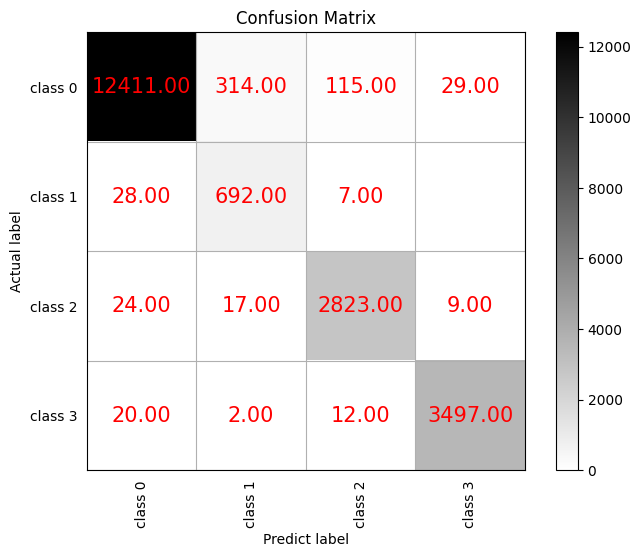

              precision    recall  f1-score   support

     class 0     0.9942    0.9644    0.9791     12869
     class 1     0.6751    0.9519    0.7900       727
     class 2     0.9547    0.9826    0.9684      2873
     class 3     0.9893    0.9904    0.9898      3531

    accuracy                         0.9711     20000
   macro avg     0.9033    0.9723    0.9318     20000
weighted avg     0.9761    0.9711    0.9726     20000



In [17]:
model = DilationNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(u_X_train, u_y_train, epochs=30)
model.evaluate(X_test, y_test, verbose=2)

y_pred = model.predict(X_test).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))
model.save_weights("./saved_models/DilationNet_1_2_2_1_default/DilationNet_1_2_2_1_default")

可以看到即使只使用10000条数据获得的模型效果也还不错，我们尝试使用不同的抽样数据训练10个Net1然后集成：

In [22]:
models = []
for i in range(10):
    print(f'model{i}')
    u_X_train, u_y_train = uniform_sample(X_train.numpy(), y_train.numpy(), 2500, 4, random_seed=i)
    u_X_train, u_y_train = tf.constant(u_X_train), tf.constant(u_y_train)
    model = DilationNet()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(u_X_train, u_y_train, epochs=30)
    model.evaluate(X_test, y_test, verbose=2)
    models.append(model)
    model.save_weights(f"./saved_models/2_2_2_default/net1_model{i}/net1_model{i}")

model0
Train on 10000 samples
Epoch 1/30
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.4773 - accuracy: 0.8093
Epoch 2/30
10000/10000 [==============================] - 10s 952us/sample - loss: 0.2376 - accuracy: 0.9094
Epoch 3/30
10000/10000 [==============================] - 10s 952us/sample - loss: 0.1728 - accuracy: 0.9374
Epoch 4/30
10000/10000 [==============================] - 9s 950us/sample - loss: 0.1343 - accuracy: 0.9521
Epoch 5/30
10000/10000 [==============================] - 9s 950us/sample - loss: 0.1190 - accuracy: 0.9575
Epoch 6/30
10000/10000 [==============================] - 9s 950us/sample - loss: 0.0937 - accuracy: 0.9669
Epoch 7/30
10000/10000 [==============================] - 9s 949us/sample - loss: 0.0842 - accuracy: 0.9696
Epoch 8/30
10000/10000 [==============================] - 9s 948us/sample - loss: 0.0752 - accuracy: 0.9728
Epoch 9/30
10000/10000 [==============================] - 10s 951us/sample - loss: 0.0578 - accuracy: 0.9

In [7]:
models = []
for i in range(10):
    model = Net1()
    model.load_weights(f"./saved_models/2_2_2_default/net1_model{i}/net1_model{i}")
    models.append(model)

In [12]:
def ensemble_models(X, models:list, method='mean'):
    y = 0
    assert len(models) > 0, "至少要有一个模型！"
    if method == 'mean':
        for model in models:
            y += model.predict(X)
        print(y)
        y /= len(models)
    else:
        raise NotImplementedError
    return y

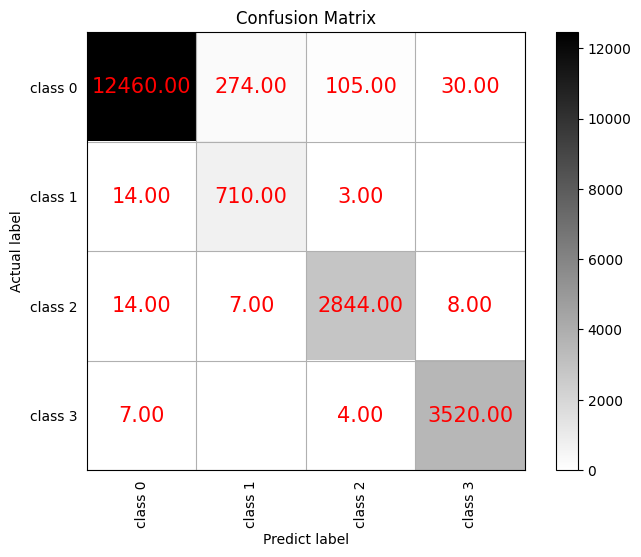

              precision    recall  f1-score   support

     class 0     0.9972    0.9682    0.9825     12869
     class 1     0.7164    0.9766    0.8265       727
     class 2     0.9621    0.9899    0.9758      2873
     class 3     0.9893    0.9969    0.9931      3531

    accuracy                         0.9767     20000
   macro avg     0.9163    0.9829    0.9445     20000
weighted avg     0.9806    0.9767    0.9777     20000



In [15]:
y_pred = ensemble_models(X_test, models).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))

可以看到虽然集成后的模型比之前单个模型的精度上升了，但是仍然不如前面之前数据增强后训练出的单个模型的效果好。

# 3 结合数据增强和模型集成策略获取预测结果

## 3.1 使用增强后的数据训练强模型

In [6]:
# 使用 SMOTE 对数据进行上采样以解决类别不平衡问题
smote = SMOTE(random_state=random_seed, n_jobs=-1)
k_X_train, k_y_train = smote.fit_resample(tf.reshape(X_train, (X_train.shape[0], X_train.shape[1])), y_train)  
k_X_train = tf.expand_dims(k_X_train, 2)
print(f"after smote, k_X_train.shape: {k_X_train.shape}, k_y_train.shape: {k_y_train.shape}")

k_y_train = tf.constant(k_y_train)

after smote, k_X_train.shape: (205832, 205, 1), k_y_train.shape: (205832,)


### 3.1.1 DilationNet

Train on 205832 samples, validate on 20000 samples
Epoch 1/30
205832/205832 [==============================] - 25s 122us/sample - loss: 0.1100 - accuracy: 0.9604 - val_loss: 0.0687 - val_accuracy: 0.9792
Epoch 2/30
205832/205832 [==============================] - 24s 116us/sample - loss: 0.0379 - accuracy: 0.9874 - val_loss: 0.0479 - val_accuracy: 0.9872
Epoch 3/30
205832/205832 [==============================] - 24s 116us/sample - loss: 0.0260 - accuracy: 0.9918 - val_loss: 0.0404 - val_accuracy: 0.9883
Epoch 4/30
205832/205832 [==============================] - 24s 116us/sample - loss: 0.0203 - accuracy: 0.9935 - val_loss: 0.0338 - val_accuracy: 0.9916
Epoch 5/30
205832/205832 [==============================] - 24s 116us/sample - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0413 - val_accuracy: 0.9909
Epoch 6/30
205832/205832 [==============================] - 24s 116us/sample - loss: 0.0152 - accuracy: 0.9953 - val_loss: 0.0456 - val_accuracy: 0.9891
Epoch 7/30
205832/205832 [=====

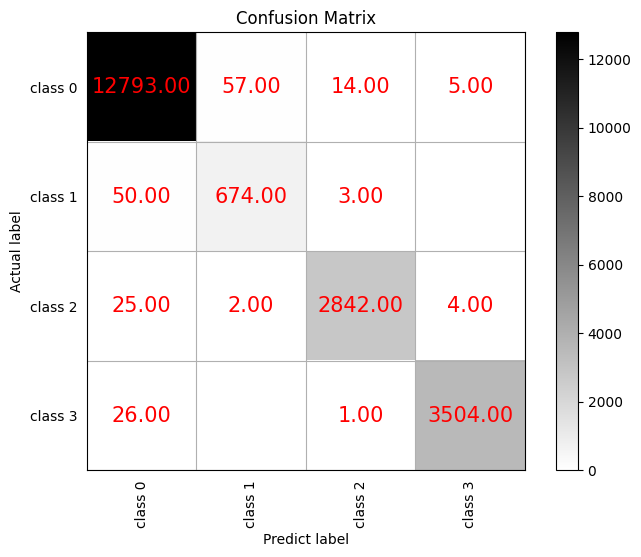

              precision    recall  f1-score   support

     class 0     0.9922    0.9941    0.9931     12869
     class 1     0.9195    0.9271    0.9233       727
     class 2     0.9937    0.9892    0.9915      2873
     class 3     0.9974    0.9924    0.9949      3531

    accuracy                         0.9907     20000
   macro avg     0.9757    0.9757    0.9757     20000
weighted avg     0.9907    0.9907    0.9907     20000



In [23]:
model = DilationNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(k_X_train, k_y_train, epochs=30, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test, verbose=2)

y_pred = model.predict(X_test).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))
model.save_weights("./saved_models/DilationNet_3_1_default/DilationNet_3_1_default")

### 3.1.2 VGG16

Train on 205832 samples, validate on 20000 samples
Epoch 1/20
205832/205832 [==============================] - 91s 442us/sample - loss: 0.1589 - accuracy: 0.9467 - val_loss: 0.1196 - val_accuracy: 0.9607
Epoch 2/20
205832/205832 [==============================] - 85s 413us/sample - loss: 0.0635 - accuracy: 0.9807 - val_loss: 0.1155 - val_accuracy: 0.9638
Epoch 3/20
205832/205832 [==============================] - 85s 413us/sample - loss: 0.0414 - accuracy: 0.9879 - val_loss: 0.0590 - val_accuracy: 0.9829
Epoch 4/20
205832/205832 [==============================] - 85s 414us/sample - loss: 0.0290 - accuracy: 0.9916 - val_loss: 0.0718 - val_accuracy: 0.9782
Epoch 5/20
205832/205832 [==============================] - 85s 413us/sample - loss: 0.0240 - accuracy: 0.9934 - val_loss: 0.0552 - val_accuracy: 0.9849
Epoch 6/20
205832/205832 [==============================] - 85s 414us/sample - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.0948 - val_accuracy: 0.9779
Epoch 7/20
205832/205832 [=====

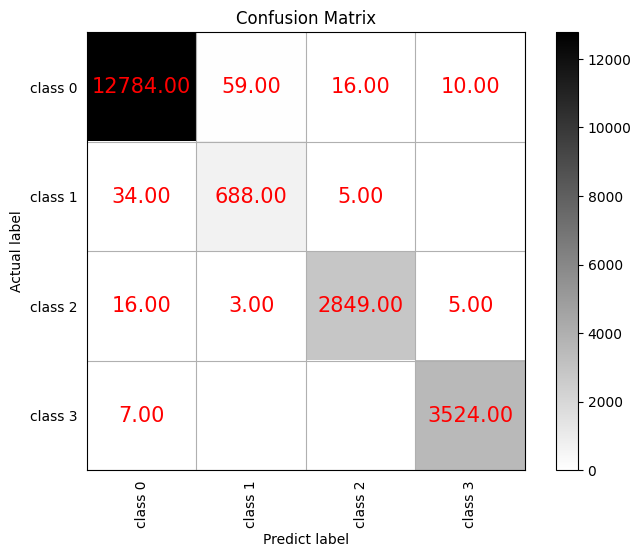

              precision    recall  f1-score   support

     class 0     0.9956    0.9934    0.9945     12869
     class 1     0.9173    0.9464    0.9316       727
     class 2     0.9927    0.9916    0.9922      2873
     class 3     0.9958    0.9980    0.9969      3531

    accuracy                         0.9922     20000
   macro avg     0.9753    0.9824    0.9788     20000
weighted avg     0.9923    0.9922    0.9923     20000



In [7]:
model = VGG16()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(k_X_train, k_y_train, epochs=20, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test, verbose=2)

y_pred = model.predict(X_test).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))
model.save_weights("./saved_models/VGG16_3_1_default/VGG16_3_1_default")

### 3.1.3 ResNet18

Train on 205832 samples, validate on 20000 samples
Epoch 1/20
205832/205832 [==============================] - 114s 553us/sample - loss: 0.1603 - accuracy: 0.9501 - val_loss: 0.1037 - val_accuracy: 0.9694
Epoch 2/20
205832/205832 [==============================] - 109s 527us/sample - loss: 0.0570 - accuracy: 0.9847 - val_loss: 0.0645 - val_accuracy: 0.9839
Epoch 3/20
205832/205832 [==============================] - 110s 533us/sample - loss: 0.0377 - accuracy: 0.9905 - val_loss: 0.0597 - val_accuracy: 0.9868
Epoch 4/20
205832/205832 [==============================] - 109s 529us/sample - loss: 0.0266 - accuracy: 0.9941 - val_loss: 0.1089 - val_accuracy: 0.9669
Epoch 5/20
205832/205832 [==============================] - 109s 528us/sample - loss: 0.0219 - accuracy: 0.9951 - val_loss: 0.0533 - val_accuracy: 0.9879
Epoch 6/20
205832/205832 [==============================] - 109s 531us/sample - loss: 0.0173 - accuracy: 0.9965 - val_loss: 0.0943 - val_accuracy: 0.9724
Epoch 7/20
205832/205832 

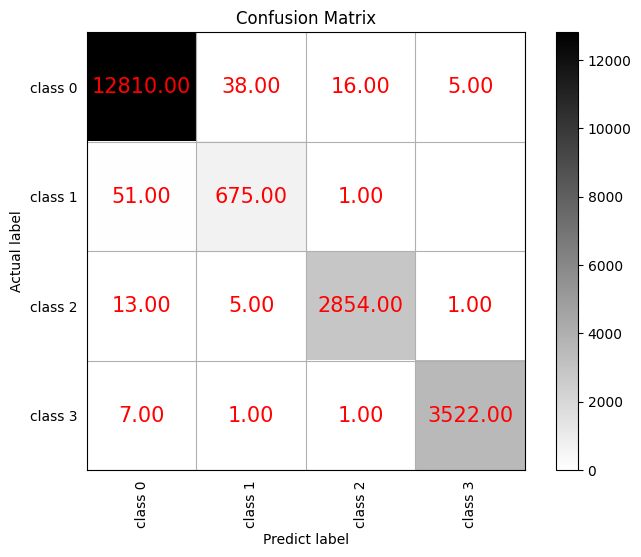

              precision    recall  f1-score   support

     class 0     0.9945    0.9954    0.9950     12869
     class 1     0.9388    0.9285    0.9336       727
     class 2     0.9937    0.9934    0.9936      2873
     class 3     0.9983    0.9975    0.9979      3531

    accuracy                         0.9930     20000
   macro avg     0.9813    0.9787    0.9800     20000
weighted avg     0.9930    0.9930    0.9930     20000



In [32]:
model = ResNet18([2, 2, 2, 2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(k_X_train, k_y_train, epochs=20, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test, verbose=2)

y_pred = model.predict(X_test).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))
model.save_weights("./saved_models/ResNet18_3_1_default/ResNet18_3_1_default")

### 3.1.3 simple LSTM

Train on 205832 samples, validate on 20000 samples
Epoch 1/20
205832/205832 [==============================] - 66s 320us/sample - loss: 0.9645 - accuracy: 0.5632 - val_loss: 0.7721 - val_accuracy: 0.7577
Epoch 2/20
205832/205832 [==============================] - 63s 307us/sample - loss: 0.5389 - accuracy: 0.7975 - val_loss: 0.4770 - val_accuracy: 0.8533
Epoch 3/20
205832/205832 [==============================] - 63s 307us/sample - loss: 0.4099 - accuracy: 0.8539 - val_loss: 0.3305 - val_accuracy: 0.8977
Epoch 4/20
205832/205832 [==============================] - 63s 308us/sample - loss: 0.3367 - accuracy: 0.8801 - val_loss: 0.3734 - val_accuracy: 0.8701
Epoch 5/20
205832/205832 [==============================] - 63s 307us/sample - loss: 0.2939 - accuracy: 0.8965 - val_loss: 0.3615 - val_accuracy: 0.8605
Epoch 6/20
205832/205832 [==============================] - 63s 308us/sample - loss: 0.2699 - accuracy: 0.9065 - val_loss: 0.2781 - val_accuracy: 0.8978
Epoch 7/20
205832/205832 [=====

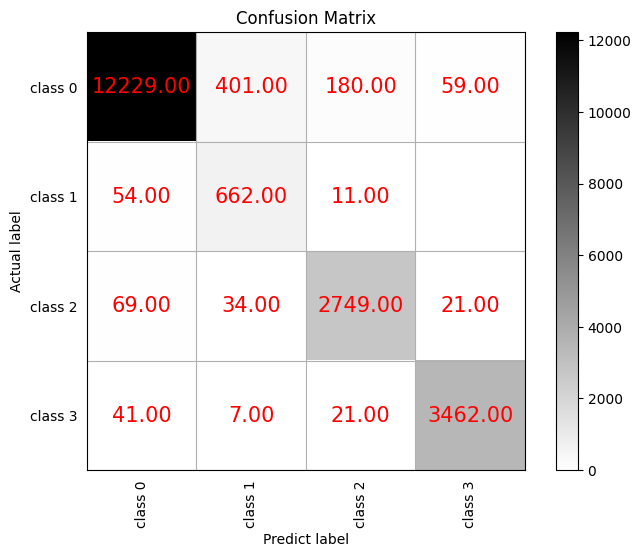

              precision    recall  f1-score   support

     class 0     0.9868    0.9503    0.9682     12869
     class 1     0.5996    0.9106    0.7231       727
     class 2     0.9284    0.9568    0.9424      2873
     class 3     0.9774    0.9805    0.9789      3531

    accuracy                         0.9551     20000
   macro avg     0.8731    0.9495    0.9032     20000
weighted avg     0.9627    0.9551    0.9575     20000



In [10]:
model = tf.keras.Sequential([LSTM(100, input_shape=(205, 1)),
                            Dropout(0.5),
                            Dense(100, activation='relu'),
                           Dense(4, activation='softmax')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(k_X_train, k_y_train, epochs=20, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test, verbose=2)

y_pred = model.predict(X_test).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))

Train on 205832 samples, validate on 20000 samples
Epoch 1/20
205832/205832 [==============================] - 132s 641us/sample - loss: 0.8529 - accuracy: 0.6408 - val_loss: 0.7834 - val_accuracy: 0.6822
Epoch 2/20
205832/205832 [==============================] - 129s 628us/sample - loss: 0.9102 - accuracy: 0.6248 - val_loss: 1.1399 - val_accuracy: 0.4532
Epoch 3/20
205832/205832 [==============================] - 129s 627us/sample - loss: 0.6534 - accuracy: 0.7439 - val_loss: 0.6351 - val_accuracy: 0.7961
Epoch 4/20
205832/205832 [==============================] - 130s 630us/sample - loss: 0.6160 - accuracy: 0.7563 - val_loss: 0.6205 - val_accuracy: 0.7908
Epoch 5/20
205832/205832 [==============================] - 129s 629us/sample - loss: 0.4126 - accuracy: 0.8446 - val_loss: 0.3744 - val_accuracy: 0.8917
Epoch 6/20
205832/205832 [==============================] - 129s 628us/sample - loss: 0.2814 - accuracy: 0.8944 - val_loss: 0.2880 - val_accuracy: 0.9118
Epoch 7/20
205832/205832 

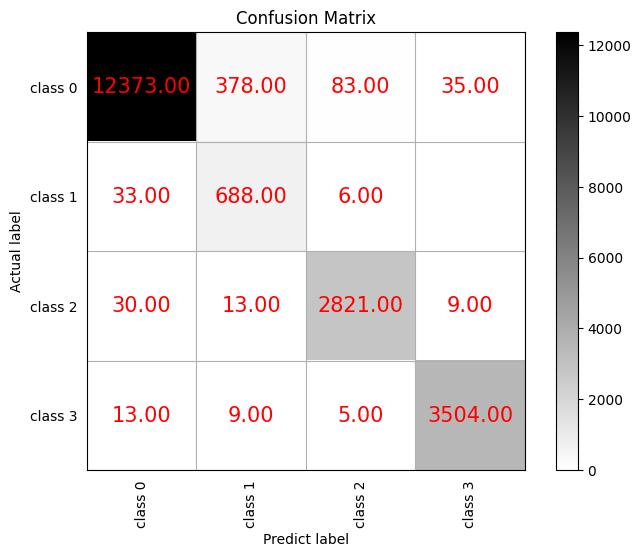

              precision    recall  f1-score   support

     class 0     0.9939    0.9615    0.9774     12869
     class 1     0.6324    0.9464    0.7581       727
     class 2     0.9678    0.9819    0.9748      2873
     class 3     0.9876    0.9924    0.9900      3531

    accuracy                         0.9693     20000
   macro avg     0.8954    0.9705    0.9251     20000
weighted avg     0.9759    0.9693    0.9713     20000



In [14]:
model = simple_LSTM()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(k_X_train, k_y_train, epochs=20, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test, verbose=2)

y_pred = model.predict(X_test).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))

In [15]:
model.fit(k_X_train, k_y_train, epochs=10, validation_data=(X_test, y_test))

Train on 205832 samples, validate on 20000 samples
Epoch 1/10
205832/205832 [==============================] - 129s 629us/sample - loss: 0.0511 - accuracy: 0.9829 - val_loss: 0.0841 - val_accuracy: 0.9708
Epoch 2/10
205832/205832 [==============================] - 129s 628us/sample - loss: 0.0492 - accuracy: 0.9839 - val_loss: 0.1176 - val_accuracy: 0.9622
Epoch 3/10
205832/205832 [==============================] - 130s 629us/sample - loss: 0.0468 - accuracy: 0.9845 - val_loss: 0.1448 - val_accuracy: 0.9487
Epoch 4/10
205832/205832 [==============================] - 129s 627us/sample - loss: 0.0444 - accuracy: 0.9852 - val_loss: 0.0871 - val_accuracy: 0.9713
Epoch 5/10
205832/205832 [==============================] - 130s 629us/sample - loss: 0.0421 - accuracy: 0.9861 - val_loss: 0.0747 - val_accuracy: 0.9753
Epoch 6/10
205832/205832 [==============================] - 129s 628us/sample - loss: 0.0410 - accuracy: 0.9864 - val_loss: 0.0652 - val_accuracy: 0.9800
Epoch 7/10
205832/205832 

In [16]:
model.save("./saved_models/simpleLSTM_3_1_default/simpleLSTM_3_1_default")

INFO:tensorflow:Assets written to: ./saved_models/simpleLSTM_3_1_default/simpleLSTM_3_1_default/assets


### 3.1.4 CNN-LSTM

In [7]:
model = CNN_LSTM()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train on 205832 samples, validate on 20000 samples
Epoch 1/30
205832/205832 [==============================] - 29s 141us/sample - loss: 0.2223 - accuracy: 0.9146 - val_loss: 0.1785 - val_accuracy: 0.9396
Epoch 2/30
205832/205832 [==============================] - 24s 118us/sample - loss: 0.0672 - accuracy: 0.9770 - val_loss: 0.1096 - val_accuracy: 0.9618
Epoch 3/30
205832/205832 [==============================] - 24s 119us/sample - loss: 0.0437 - accuracy: 0.9858 - val_loss: 0.0838 - val_accuracy: 0.9729
Epoch 4/30
205832/205832 [==============================] - 25s 120us/sample - loss: 0.0339 - accuracy: 0.9893 - val_loss: 0.0658 - val_accuracy: 0.9787
Epoch 5/30
205832/205832 [==============================] - 25s 120us/sample - loss: 0.0268 - accuracy: 0.9917 - val_loss: 0.0931 - val_accuracy: 0.9727
Epoch 6/30
205832/205832 [==============================] - 24s 119us/sample - loss: 0.0227 - accuracy: 0.9930 - val_loss: 0.1061 - val_accuracy: 0.9690
Epoch 7/30
205832/205832 [=====

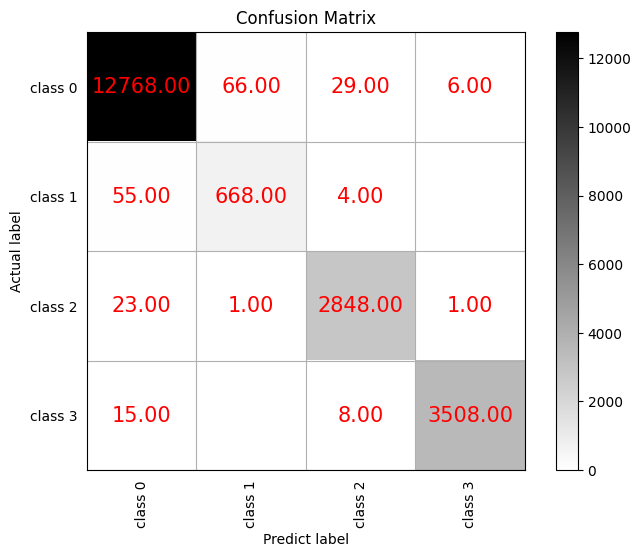

              precision    recall  f1-score   support

     class 0     0.9928    0.9922    0.9925     12869
     class 1     0.9088    0.9188    0.9138       727
     class 2     0.9858    0.9913    0.9885      2873
     class 3     0.9980    0.9935    0.9957      3531

    accuracy                         0.9896     20000
   macro avg     0.9714    0.9739    0.9726     20000
weighted avg     0.9896    0.9896    0.9896     20000

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_models/CNN_LSTM_3_1_default/CNN_LSTM_3_1_default/assets


In [8]:
model.fit(tf.reshape(k_X_train, (-1, 5, 41, 1)), k_y_train, epochs=30, validation_data=(tf.reshape(X_test, (-1, 5, 41, 1)), y_test))
model.evaluate(tf.reshape(X_test,  (-1, 5, 41, 1)), y_test, verbose=2)

y_pred = model.predict(tf.reshape(X_test, (-1, 5, 41, 1))).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))
model.save("./saved_models/CNN_LSTM_3_1_default/CNN_LSTM_3_1_default")

### 3.1.5 ConvLSTM

In [12]:
model = ConvLSTM()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train on 205832 samples, validate on 20000 samples
Epoch 1/30
205832/205832 [==============================] - 90s 438us/sample - loss: 0.2655 - accuracy: 0.8966 - val_loss: 0.1265 - val_accuracy: 0.9607
Epoch 2/30
205832/205832 [==============================] - 86s 420us/sample - loss: 0.1097 - accuracy: 0.9616 - val_loss: 0.1346 - val_accuracy: 0.9548
Epoch 3/30
205832/205832 [==============================] - 86s 420us/sample - loss: 0.0750 - accuracy: 0.9738 - val_loss: 0.0792 - val_accuracy: 0.9755
Epoch 4/30
205832/205832 [==============================] - 86s 419us/sample - loss: 0.0559 - accuracy: 0.9808 - val_loss: 0.0764 - val_accuracy: 0.9768
Epoch 5/30
205832/205832 [==============================] - 86s 420us/sample - loss: 0.0454 - accuracy: 0.9844 - val_loss: 0.0949 - val_accuracy: 0.9711
Epoch 6/30
205832/205832 [==============================] - 86s 419us/sample - loss: 0.0384 - accuracy: 0.9868 - val_loss: 0.0593 - val_accuracy: 0.9842
Epoch 7/30
205832/205832 [=====

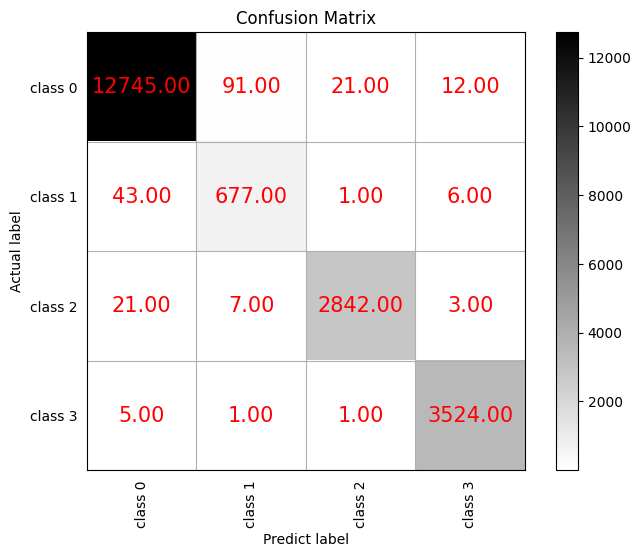

              precision    recall  f1-score   support

     class 0     0.9946    0.9904    0.9925     12869
     class 1     0.8724    0.9312    0.9009       727
     class 2     0.9920    0.9892    0.9906      2873
     class 3     0.9941    0.9980    0.9960      3531

    accuracy                         0.9894     20000
   macro avg     0.9633    0.9772    0.9700     20000
weighted avg     0.9897    0.9894    0.9895     20000



In [13]:
model.fit(tf.reshape(k_X_train, (-1, 5, 1, 41, 1)), k_y_train, epochs=30, validation_data=(tf.reshape(X_test, (-1, 5, 1, 41, 1)), y_test))
model.evaluate(tf.reshape(X_test,  (-1, 5, 1, 41, 1)), y_test, verbose=2)

y_pred = model.predict(tf.reshape(X_test, (-1, 5, 1, 41, 1))).argmax(axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))

In [14]:
model.save("./saved_models/ConvLSTM_3_1_default/ConvLSTM_3_1_default")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_models/ConvLSTM_3_1_default/ConvLSTM_3_1_default/assets


## 3.2 集成强模型

In [16]:
models = {}
model = DilationNet()
model.load_weights("./saved_models/DilationNet_3_1_default/DilationNet_3_1_default")
models['DilationNet'] = model
model = VGG16()
model.load_weights("./saved_models/VGG16_3_1_default/VGG16_3_1_default")
models['VGG16'] = model
model = ResNet18([2, 2, 2, 2])
model.load_weights("./saved_models/ResNet18_3_1_default/ResNet18_3_1_default")
models['ResNet18'] = model
for net in ['CNN_LSTM', 'ConvLSTM', 'simpleLSTM']:
    models[net] = tf.keras.models.load_model(f"./saved_models/{net}_3_1_default/{net}_3_1_default")

In [17]:
models

{'DilationNet': <lxh_models.DilationNet at 0x7f312470c950>,
 'VGG16': <lxh_models.VGG16 at 0x7f3124730210>,
 'ResNet18': <lxh_models.ResNet18 at 0x7f31246b3a90>,
 'CNN_LSTM': <tensorflow.python.keras.saving.saved_model.load.Sequential at 0x7f311411a590>,
 'ConvLSTM': <tensorflow.python.keras.saving.saved_model.load.Sequential at 0x7f30dc06c910>,
 'simpleLSTM': <tensorflow.python.keras.saving.saved_model.load.Sequential at 0x7f303859ea90>}

In [19]:
def ensemble_Powerful_models(models, X, soft_pred=False):
    y_pred = 0
    for net in models.keys():
        if net == 'CNN_LSTM':
            y_pred += models[net].predict(tf.reshape(X,  (-1, 5, 41, 1)))
        elif net == 'ConvLSTM':
            y_pred += models[net].predict(tf.reshape(X, (-1, 5, 1, 41, 1)))
        else:
            y_pred += models[net].predict(tf.reshape(X, (-1, 205, 1)))
    y_pred /= len(models)
    if soft_pred:
        return y_pred
    else:
        return y_pred.argmax(axis=1)

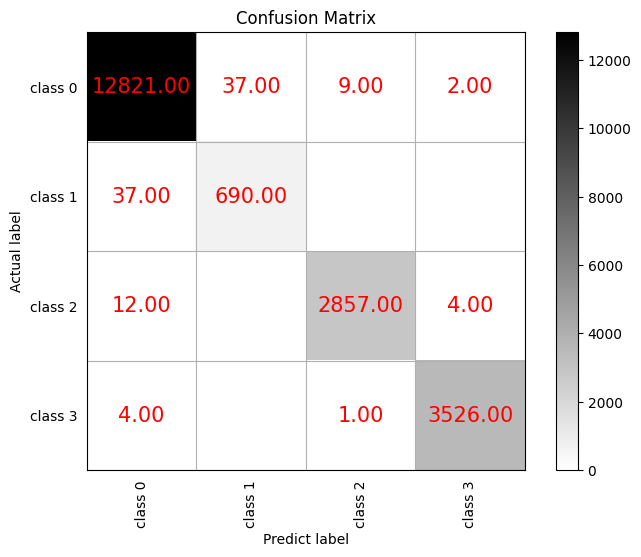

              precision    recall  f1-score   support

     class 0     0.9959    0.9963    0.9961     12869
     class 1     0.9491    0.9491    0.9491       727
     class 2     0.9965    0.9944    0.9955      2873
     class 3     0.9983    0.9986    0.9984      3531

    accuracy                         0.9947     20000
   macro avg     0.9850    0.9846    0.9848     20000
weighted avg     0.9947    0.9947    0.9947     20000



In [19]:
y_pred = ensemble_Powerful_models(models, X_test)

plot_confusion_matrix(y_test, y_pred, classes=['class 0', 'class 1', 'class 2', 'class 3'], title='Confusion Matrix')
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2', 'class 3'], digits=4))

可以看到，集成的效果非常好，超过了之前任何一个单独的模型。

## 3.3 获得最终结果

In [9]:
model1 = ResNet18([2, 2, 2, 2])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model1.load_weights("./saved_models/ResNet18_3_1_default/ResNet18_3_1_default")
model1.evaluate(X_test, y_test)

20000/20000 [==============================] - 25s 1ms/sample - loss: 0.0310 - accuracy: 0.9930


[0.030971606697328388, 0.99305]

In [14]:
y_pred = model1.predict(tf.reshape(X_testA, (-1, 205, 1))).argmax(axis=1)
testA_result_hard = pd.DataFrame(tf.one_hot(y_pred, 4).numpy(), index=testA_data['id'], columns=[f'label_{i}' for i in range(4)])
testA_result_hard.head(10)

,label_0,label_1,label_2,label_3
id,,,,
100000,1.0,0.0,0.0,0.0
100001,0.0,0.0,1.0,0.0
100002,0.0,0.0,0.0,1.0
100003,1.0,0.0,0.0,0.0
100004,1.0,0.0,0.0,0.0


In [10]:
testA_data = pd.read_csv('./testA.csv')
X_testA = []
for signal in testA_data['heartbeat_signals']:
    X_testA.append(np.array(signal.split(','), dtype=np.float32))
X_testA = tf.constant(np.array(X_testA))

### 3.3.1 使用强集成模型进行预测

In [20]:
y_pred = ensemble_Powerful_models(models, X_testA)

In [33]:
tf.one_hot(y_pred, 4).numpy().shape

(20000, 4)

In [21]:
testA_result_hard = pd.DataFrame(tf.one_hot(y_pred, 4).numpy(), index=testA_data['id'], columns=[f'label_{i}' for i in range(4)])

In [22]:
testA_result_hard.head()

,label_0,label_1,label_2,label_3
id,,,,
100000,1.0,0.0,0.0,0.0
100001,0.0,0.0,1.0,0.0
100002,0.0,0.0,0.0,1.0
100003,1.0,0.0,0.0,0.0
100004,1.0,0.0,0.0,0.0


In [23]:
testA_result_hard.to_csv('submit_3_3_1_hard.csv')

In [41]:
y_pred = ensemble_Powerful_models(models, X_testA, soft_pred=True)

In [44]:
testA_result_soft = pd.DataFrame(y_pred, index=testA_data['id'], columns=[f'label_{i}' for i in range(4)])

In [45]:
testA_result_soft.head()

,label_0,label_1,label_2,label_3
id,,,,
100000,0.999936,1.150589e-05,2.336776e-05,2.919941e-05
100001,0.999993,4.635496e-07,5.366042e-06,1.603534e-06
100002,0.999773,2.149079e-04,1.153025e-05,3.869142e-07
100003,0.000008,2.131492e-06,6.047554e-08,9.999900e-01
100004,0.999968,2.475397e-05,5.096042e-06,1.974447e-06


In [46]:
testA_result_soft.to_csv('submit_3_3_1_soft.csv')

In [ ]:
import moxing as mox
mox.file.copy_parallel('saved_models','obs://lixinhao-bin/baseline/saved_models')

### 3.3.2 使用全部数据训练模型后集成进行预测

从头训练量有点大，先用上一节的模型在测试集上训几遍将就将就：

In [ ]:
##